# Import

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
from scipy.stats import norm, rayleigh, gamma
from tools import get_mids
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use("../style.mplstyle")
warnings.filterwarnings("ignore")


Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Code from Rob

In [2]:
filname = "../resources/Linefit_angular_resolution_dataframe.csv"
dat = np.genfromtxt(filname, delimiter=",", names=True)


In [3]:
dat.dtype.names

('event_id',
 'resolution_linefit',
 'resolution_linefitNew',
 'zenith_angle',
 'zenith_linefit',
 'muon_energy',
 'aeffs')

# angular resolution

In [4]:
from scipy.stats import t, norm, cauchy


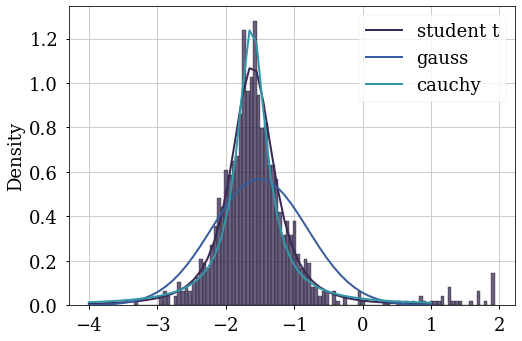

In [5]:
sns.histplot(np.log10(dat["resolution_linefitNew"]), bins=100, stat="density")

fit_t = t.fit(np.log10(dat["resolution_linefitNew"]))
fit_gauss = norm.fit(np.log10(dat["resolution_linefitNew"]))
fit_cauchy = cauchy.fit(np.log10(dat["resolution_linefitNew"]))

xvals = np.linspace(-4, 1)
plt.plot(xvals, t.pdf(xvals, *fit_t), label="student t")
plt.plot(xvals, norm.pdf(xvals, *fit_gauss), label="gauss")
plt.plot(xvals, cauchy.pdf(xvals, *fit_cauchy), label="cauchy")
plt.legend()

In [18]:
logE_bins = np.linspace(3, 6, 20)
logE_mids = get_mids(logE_bins)

All events used: True


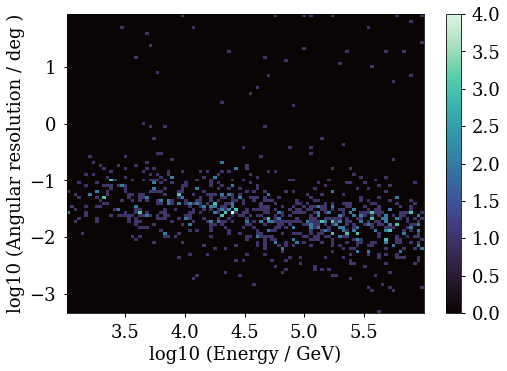

In [26]:
plt.xlabel("log10 (Energy / GeV)")
plt.ylabel("log10 (Angular resolution / deg )")
n, xbins, ybins, image = plt.hist2d(
    np.log10(dat["muon_energy"]), np.log10(dat["resolution_linefitNew"]), bins=100
)
plt.colorbar()
print(f"All events used: {len(dat)==np.sum(n)}")


In [16]:
from scipy.stats import gaussian_kde

Transformation of Psi from log10(psi) to psi^2


$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$

(0.0, 0.04000000000000001)

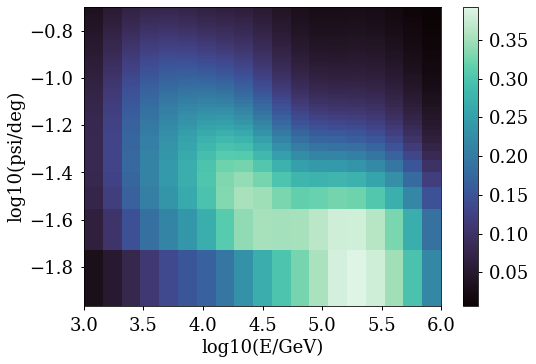

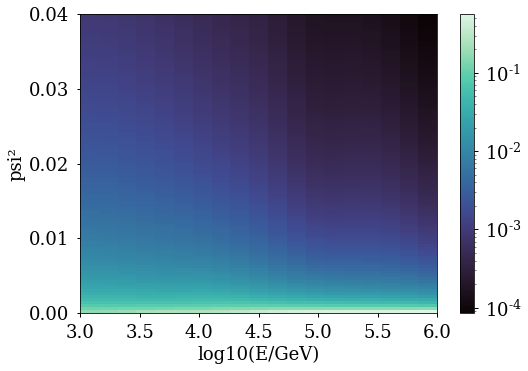

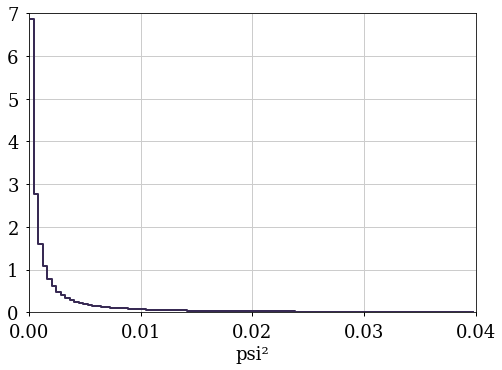

In [45]:
## set up the psi2-energy function and binning
e_psi_kdes = gaussian_kde(
    (np.log10(dat["muon_energy"]), np.log10(dat["resolution_linefitNew"])) #, bw_method=1
)

# psi² representation
delta_psi_max = 0.2
bins_per_psi2 = 50
psi2_bins = np.linspace(0, delta_psi_max**2, num=100) #, delta_psi_max**2 * bins_per_psi2 + 1)
psi2_mids = get_mids(psi2_bins)
log_psi_mids = np.log10(np.sqrt(psi2_mids))
# KDE was produced in log(E_true) and log(Psi)
e_eval, psi_eval = np.meshgrid(logE_mids, log_psi_mids)
psi_kvals = e_psi_kdes([e_eval.flatten(), psi_eval.flatten()]).reshape(
    len(log_psi_mids), len(logE_mids)
)

# new grid for analysis in psi^2 and e_true
e_grid, psi_grid = np.meshgrid(logE_mids, psi2_mids)
# transform to psi^2
e_psi2_grid = psi_kvals / psi_grid / 2 / np.log(10)
# normalize per energy to ensure that signal event numbers are not changed
e_psi2_grid /= np.sum(e_psi2_grid, axis=0)
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)

plt.figure()
plt.pcolormesh(logE_mids, log_psi_mids, psi_kvals)#, norm=LogNorm())
plt.colorbar()
plt.ylabel("log10(psi/deg)")
plt.xlabel("log10(E/GeV)")


plt.figure()
plt.pcolormesh(logE_mids, psi2_mids, e_psi2_grid, norm=LogNorm())
plt.colorbar()
plt.ylabel("psi²")
plt.xlabel("log10(E/GeV)")

plt.figure()
plt.plot(psi2_mids, e_psi2_grid.sum(axis=1), ds="steps-mid")
plt.xlabel("psi²")
plt.ylim(0, 7)
plt.xlim(0, delta_psi_max ** 2)

# effective area

All events used: False


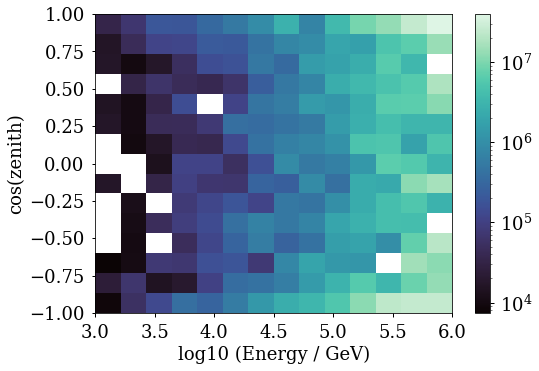

In [52]:
plt.xlabel("log10 (Energy / GeV)")
plt.ylabel("cos(zenith)")
logebins = np.linspace(3, 6, 15)
logemids = get_mids(logebins)
coszenbins = np.linspace(-1, 1, 16)
coszenmids = get_mids(coszenbins)
n_aeff, xbins, ybins, image = plt.hist2d(
    np.log10(dat["muon_energy"]),
    np.cos(dat["zenith_angle"]),
    bins=[logebins, coszenbins],
    weights=dat["aeffs"] / 1E4, # cm^2 -> m^2
    norm=LogNorm(),
)
plt.colorbar()
print(f"All events used: {len(dat)==np.sum(n)}")


## smoothed aeff (WIP??)

In [63]:
loge_eval, coszen_eval = np.meshgrid(logemids, coszenmids)

aeff_kde = gaussian_kde(
    (loge_eval.flatten(), coszen_eval.flatten()), weights=n_aeff.T.flatten()
)

aeff_smoothed = e_psi_kdes([loge_eval.flatten(), coszen_eval.flatten()]).reshape(
    len(coszenmids), len(logemids)
)


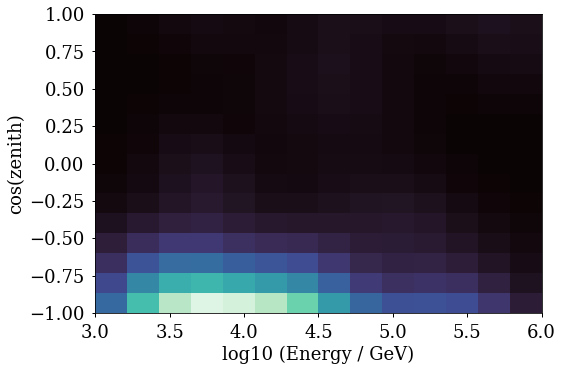

In [64]:
plt.xlabel("log10 (Energy / GeV)")
plt.ylabel("cos(zenith)")
plt.pcolormesh(logebins, coszenbins, aeff_smoothed)

# WIP

All events used: True


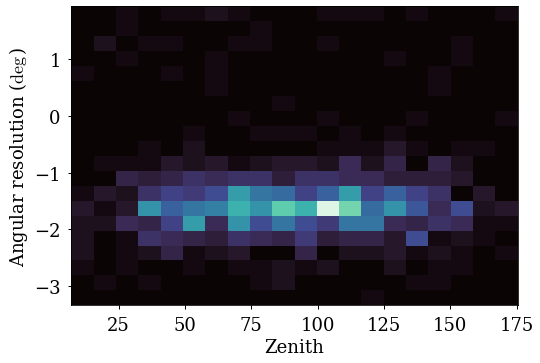

In [12]:

plt.xlabel("Zenith")
plt.ylabel("Angular resolution ($\deg$)")
n, xbins, ybins, image = plt.hist2d(
    dat["zenith_angle"], np.log10(dat["resolution_linefitNew"]), bins=[20, 20]
)
print(f"All events used: {len(dat)==np.sum(n)}")


All events used: True


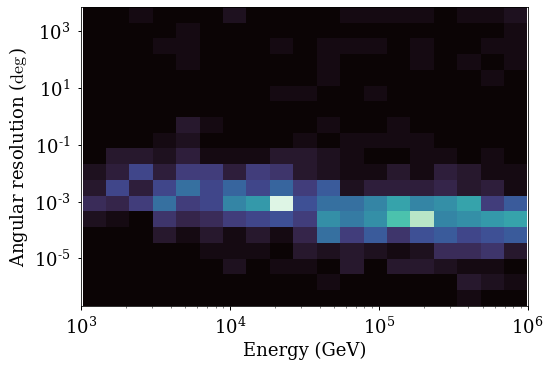

In [ ]:
eps = 1e-10
angmin = (np.min(dat["resolution_linefitNew"]) - eps) ** 2
angmax = (np.max(dat["resolution_linefitNew"]) + eps) ** 2
engmin = np.min(dat["muon_energy"]) - eps
engmax = np.max(dat["muon_energy"]) + eps


angbins = np.logspace(np.log10(angmin), np.log10(angmax), 20)
engbins = np.logspace(np.log10(engmin), np.log10(engmax), 20)

plt.xlabel("Energy (GeV)")
plt.ylabel("Angular resolution ($\deg$)")
n, xbins, ybins, image = plt.hist2d(
    dat["muon_energy"], dat["resolution_linefitNew"] ** 2, bins=[engbins, angbins]
)
plt.yscale("log")
plt.xscale("log")
plt.xlim(1E3, 1E6)

print(f"All events used: {len(dat)==np.sum(n)}")
